In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 10.0)
import matplotlib.gridspec as gridspec
import torch
import torch.nn as nn
from PIL import Image
from scipy.signal import convolve2d
from skimage.measure import block_reduce, find_contours
from matplotlib.patches import Rectangle
from kural_core.models import *
from kural_core.data_processing import *
from kural_core.functions import *
from kural_core.train_model import train_model
import pickle
from scipy.misc import imresize
from scipy.ndimage import morphology
from scipy.spatial import ConvexHull
from skimage import measure
from matplotlib import animation, rc
from IPython.display import HTML, display, clear_output
from os import listdir
from nd2reader import ND2Reader
from ipywidgets import widgets, Layout

PATH = r'D:\Code\kural_work\actin_gan_data\\'

In [2]:
with open(PATH+'he_le_tuple.pickle','rb') as f:
    he, le = pickle.load(f)

In [3]:
ds = ActinGanDataset(he, le)

In [4]:
with open(PATH+'good_high_and_low.pickle','rb') as f:
    good = pickle.load(f)
is_good = []
for i in range(good[0].shape[0]):
    is_good.append((good[0][i][None],good[1][i][None]))

In [35]:
def display_imgs():
    clear_output(wait=True)
    fig, ax = plt.subplots(1,2,figsize=(16,14))
    chance = 0
    while chance<0.5:
        idx = np.random.choice(len(ds))
        h,l = ds[idx]
        chance = nn.Softmax(1)(classifier_model((h.cuda()-mini)/(maxi-mini))).data.cpu().numpy()[0,1]
    m = ax[0].imshow(h[0,0])
    plt.colorbar(mappable=m, ax=ax[0],shrink=0.4)
    m = ax[1].imshow(l[0,0])
    plt.colorbar(mappable=m, ax=ax[1],shrink=0.4)
    plt.show()
    fig.subplots_adjust(wspace=0.01, hspace=0)
    
    def yes(btn):
        is_good.append((h.clone().detach().data,l.clone().detach().data))
        print('Was good!')
        display_imgs()
    def no(btn):
        print('Was not good!')
        display_imgs()
    y = widgets.Button(description='Yes, good')
    y.on_click(yes)
    n = widgets.Button(description='No, not good')
    n.on_click(no)
    w = widgets.HBox([y, n])
    display(w)

In [22]:
auto_good = []
i = 0
while len(auto_good)<10000:
    chance = 0
    while chance<0.5:
        idx = np.random.choice(len(ds))
        h,l = ds[idx]
        chance = nn.Softmax(1)(classifier_model((h.cuda()-mini)/(maxi-mini))).data.cpu().numpy()[0,1]
        print(chance)
    auto_good.append((h.clone().detach().data,l.clone().detach().data))
    if i%99==0:
        print(i,len(auto_good)/i)

0.15277898
0.1527786
0.1527787
0.15278247
0.15277927
0.15277922
0.15278563
0.15278874
0.1527786
0.1527787
0.15277857
0.152779
0.15281357
0.15277933
0.15277916
0.1528107
0.15278487
0.15278545
0.15278152
0.35931748
0.15278056
0.1527834
0.15277979
0.1527907
0.15277915
0.15278229
0.15278383
0.15279233
0.15277879
0.15277877
0.15278022
0.15277901
0.15278092
0.15277927
0.15277927
0.15278104
0.15277892
0.15277886
0.15277982
0.15277874
0.15277912
0.15277928
0.15278104
0.15277945
0.15278167
0.15278421
0.15278034
0.15277898
0.15277888
0.15277961
0.15277903
0.15277892
0.15280254
0.15277894
0.15277883
0.15277913
0.15277952
0.15277901
0.1527788
0.15278065
0.15277952
0.15277892
0.15277867
0.15277894
0.15277913
0.15277897
0.15278007
0.15277901
0.15277974
0.15277998
0.1527981
0.15277956
0.15277961
0.15277898
0.15277901
0.15277864
0.15277939
0.15277939
0.15277922
0.15278384
0.15277855
0.15277973
0.15277879
0.15277955
0.15277892
0.15277877
0.15278071
0.15277919
0.15277947
0.1527786
0.15277857
0.15277927


KeyboardInterrupt: 

In [20]:
len(auto_good)

0

In [21]:
i

0

In [31]:
a = list('abdef')
print(a[::2])

['a', 'd', 'f']


KeyboardInterrupt: 

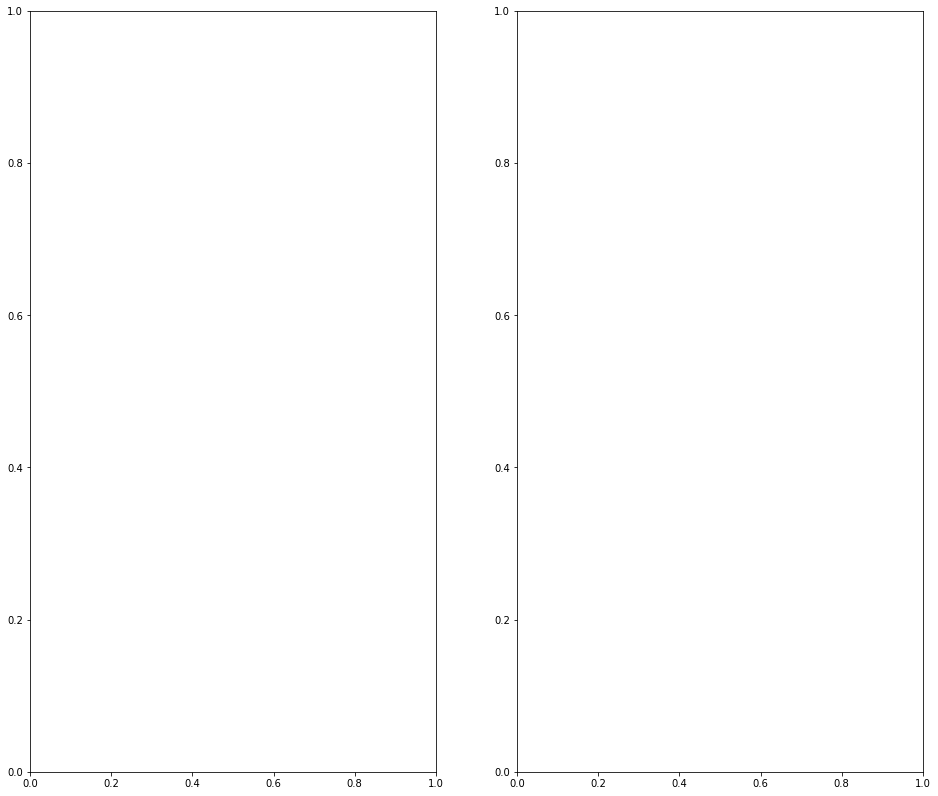

In [36]:
display_imgs()

In [32]:
good = (torch.cat([i for i,_ in is_good]),torch.cat([j for _,j in is_good]))
print(good[0].shape[0])
with open(PATH+'good_high_and_low.pickle','wb') as f:
    pickle.dump(good,f,protocol=4)

365


In [32]:
idx = np.random.choice(len(ds))
h,l = ds[idx]
print(h.shape)

torch.Size([1, 1, 128, 128])


In [67]:
classifier_model = ActinClassifierModel().cuda()

In [68]:
classifier_model.load_state_dict(torch.load(r'D:\Code\kural_work\actin_classifier_model.pth'))

In [70]:
for p in classifier_model.parameters():
    p.require_grad=False

In [69]:
classifier_model.eval()

ActinClassifierModel(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.05, inplace)
    (3): Sequential(
      (0): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace)
    )
    (4): res_block(
      (conv): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.05, inplace)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): LeakyReLU(negative_slope=0.05, inplace)
 

In [61]:
nn.Softmax(1)(classifier_model((h.cuda()-mini)/(maxi-mini))).data.cpu().numpy()[0,1]

0.13346842

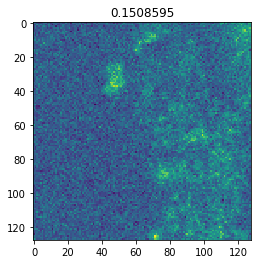

In [84]:
idx = np.random.choice(len(ds))
h,l = ds[idx]
chance = nn.Softmax(1)(classifier_model((h.cuda()-mini)/(maxi-mini))).data.cpu().numpy()[0,1]
plt.imshow(h[0,0])
plt.title(chance)
plt.show()

In [42]:
shuff_tmp = nn.PixelShuffle(2)(tmp);shuff_tmp

tensor([[[[ 0, 16,  1, 17,  2, 18,  3, 19],
          [32, 48, 33, 49, 34, 50, 35, 51],
          [ 4, 20,  5, 21,  6, 22,  7, 23],
          [36, 52, 37, 53, 38, 54, 39, 55],
          [ 8, 24,  9, 25, 10, 26, 11, 27],
          [40, 56, 41, 57, 42, 58, 43, 59],
          [12, 28, 13, 29, 14, 30, 15, 31],
          [44, 60, 45, 61, 46, 62, 47, 63]]]], dtype=torch.int32)

In [43]:
shuff_tmp.shape

torch.Size([1, 1, 8, 8])

In [51]:
test = good[0][0:1]

In [53]:
test_model = ActinUNetModel()

In [2]:
with open(PATH+'good_high_and_low.pickle','rb') as f:
    good = pickle.load(f)

In [37]:
with open(PATH+'actin_classifier_model_image_normalization.pickle','rb') as f:
    mini, maxi = pickle.load(f)

In [3]:
good = list(good)

In [4]:
for i in range(2):
    for j in range(good[i].shape[0]):
        good[i][j] = (good[i][j]-good[i][j].mean())/good[i][j].std()

In [5]:
ds = ActinUNetDataset(good)
train_idx, val_idx = RandomIndicesForKFoldValidation(len(ds), 0, K=5, rand_seed=42, nORp=1)
bs = 10
clip = 50
train_dl = torch.utils.data.DataLoader(ds,batch_size=bs, sampler=SubsetSampler(train_idx, shuffle=True))
val_dl = torch.utils.data.DataLoader(ds,batch_size=bs, sampler=SubsetSampler(val_idx))
model = ActinUNetModel().cuda()
opt = torch.optim.Adam(model.parameters())
train_loss = []
val_loss = []
# criterion = ActinUNetPerceptualLoss(classifier_model)
# criterion = nn.L1Loss()
criterion = ActinProbabalisticLoss()

In [6]:
model, _tl, _vl = train_model(model, train_dl, val_dl, opt, criterion, lr_start=1e-3, lr_end=1, epochs=100, cycles=1, lr_cycle='sin')
train_loss += _tl
val_loss += _vl
# model, _tl, _vl = train_model(model, train_dl, val_dl, opt, criterion, lr_start=1e-3, lr_end=1e-6, epochs=200, cycles=1, lr_cycle='cos')
# train_loss += _tl
# val_loss += _vl

><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><
Spent 15m 16s doing 100 total steps for an average of 9.2s per step.
><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><


In [25]:
lr_range = [1e-6*(10**(i/5)) for i in range(30)]
for lr in lr_range:
    model, _tl, _vl = train_model(model, train_dl, val_dl, opt, criterion, lr_start=lr, lr_end=None, epochs=1, cycles=1)
    train_loss += _tl
    val_loss += _vl
    if _tl[0]>100: break

><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><
Spent 0m  6s doing 1 total steps for an average of 6.1s per step.
><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><


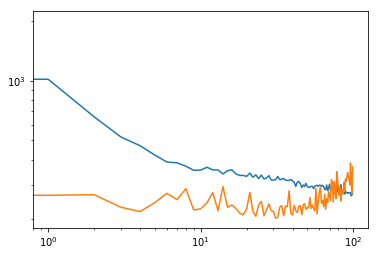

In [7]:
x = list(range(len(train_loss)))
# x = lr_range
slc = slice(0,len(train_loss))
plt.plot(x[slc],train_loss[slc])
plt.plot(x[slc],val_loss[slc])
plt.xscale('log')
plt.yscale('log')
plt.show()

In [17]:
x_test.shape

torch.Size([1, 128, 128])

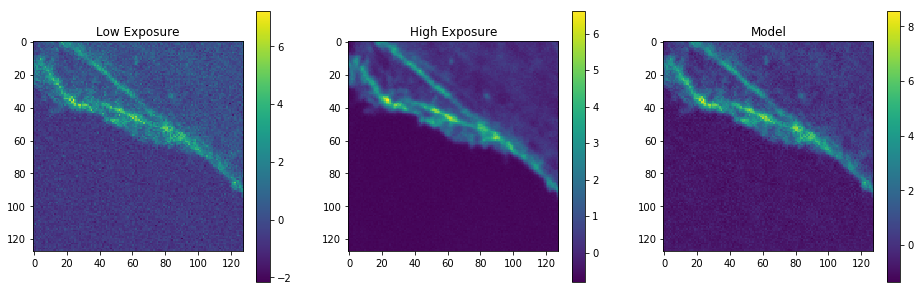

In [13]:
fig, ax = plt.subplots(1,3,figsize=(16,10))
model.eval()
idx = np.random.choice(train_idx)
x_test, y_test = ds[idx]
m = ax[0].imshow(x_test[0])
plt.colorbar(mappable=m, ax=ax[0], shrink=0.5)
ax[0].set_title('Low Exposure')
m = ax[1].imshow(y_test[0]+x_test[0])
plt.colorbar(mappable=m, ax=ax[1], shrink=0.5)
ax[1].set_title('High Exposure')
y_pred = model(x_test[None].cuda())
img_out = y_pred[0][0,0].data.cpu() + x_test[0]
m = ax[2].imshow(img_out)
plt.colorbar(mappable=m, ax=ax[2], shrink=0.5)
ax[2].set_title('Model')
plt.show()

In [42]:
lmm = list(iter(model.modules()))

In [35]:
tmp = next(imm)

In [49]:
for i, m in enumerate(lmm):
    if hasattr(m, 'stride'):
        if m.stride == (2,2):
            for j in range(i-1,-1,-1):
                if isinstance(lmm[j],nn.Conv2d):
                    print(j)
                    break

10
23
36
49
52
65
76
87


In [62]:
i=0
for j, m in enumerate(model.modules()):
    if not (isinstance(m,nn.Conv2d) or isinstance(m,nn.BatchNorm2d) or isinstance(m, nn.LeakyReLU)): continue
    if i == 0:
        out = m(x_test[None].cuda())
    else:
        out = m(out)
    i+=1
    if j==24: break

In [63]:
out.shape

torch.Size([1, 32, 64, 64])

In [74]:
aloss = ActinUNetPerceptualLoss(classifier_model)

In [102]:
aloss(model(x_test[None].cuda()),y_test[None].cuda()).cpu()

predicted shape is torch.Size([1, 1, 128, 128])
actual shape is torch.Size([1, 1, 128, 128])
predicted shape is torch.Size([1, 8, 128, 128])
actual shape is torch.Size([1, 8, 128, 128])
predicted shape is torch.Size([1, 16, 64, 64])
actual shape is torch.Size([1, 16, 64, 64])
predicted shape is torch.Size([1, 32, 32, 32])
actual shape is torch.Size([1, 32, 32, 32])


tensor(6.7990, grad_fn=<CopyBackwards>)

In [79]:
lm = list(iter(classifier_model.modules()))

In [80]:
lm[2]

Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))